In [1]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import glob as glob_lib
import sys
from pytz import timezone
import pytz
import statsmodels.tools.eval_measures as sms_eval
import seaborn as sns
import matplotlib.pyplot as plt    
from scipy import stats
import datetime


#-----------------------------------------------Helper functions------------------------------
def custom_plot(df,x='',y = '',bins = 25 ,plot = False):
    
    if(plot == 'histogram'):
        sns.displot(df,x=x,bins= bins)
    if(plot == 'regplot'):
        sns.regplot(data=df,x=x,y=y,lowess = True,scatter_kws={"color": "black"}, line_kws={"color": "red"})
        
def transform(df,column,type_= False):
    if(type_ == 'log'):
        df[str(column+'_log')] = np.log(df[column])
    if(type_ == 'square'):
         df[str(column+'_sqr')] = df[column]*df[column]
            
def makeBinary(df,column):           
    df[str('Has_'+ column)] = np.where(df[column] != 0,1,0)


In [2]:
#---------------------------------------------iMPORTING EXCEL DATA-----------------------------------------------------------#

attendance = pd.DataFrame()

data_files = glob_lib.glob('C:/Users/antho/OneDrive/Desktop/MSBA 502 - Analytical Programming/Data/*.xls*')

for file_name in (data_files):
    
    worksheet = pd.ExcelFile(file_name,engine='xlrd').book.sheets()
    #certain attributes that come from "excelfile" objects. Such as: .book.sheets()
    #.book.sheets() -> iterable "list" of sheet objects
    #sheet objects also have attributes 
    
    for sheet in (worksheet):
        #Checking for sheet visibility
        if(sheet.visibility == 0):
            
            #Checking if cell value at 1,B is 'Day' and cell value at 1,C is either 'Full Paid' or 'Full \nPaid'
            #The only data that shares this commonality is all the sheets with attendance data.
            if((sheet.cell_value(0,1) == 'Day' )&( (sheet.cell_value(0,2)== 'Full Paid')|( sheet.cell_value(0,2) == 'Full \nPaid'))):
                
                temp = pd.read_excel(file_name,sheet_name=sheet.name)
                
                #Checks and drops if any columns have values 'Pre-Pay' or 'PrePay' this occurs in the earlier excel files
                if(len(temp.columns[temp.isin(['Pre-Pay','PrePay']).any()])):
                    temp.drop(columns = temp.columns[temp.isin(['Pre-Pay','PrePay']).any()][0],inplace = True)
                
                #Checks and drops any column names that are 'Pre-Pay' or 'PrePay' this occurs in later excel files
                if('PrePay' in temp.columns): temp.drop(columns = 'PrePay',inplace = True)
                elif('Pre-Pay' in temp.columns):temp.drop(columns = 'Pre-Pay',inplace = True)
                    
                #Gathers the data up until 'Total On-Site Visitors'
                temp = temp.iloc[:,0:15]
                
                #Since all columns share the same structure, rename them as follows:
                temp.columns = ['Date', 'Day', 'Full Paid', 'Discount Paid', 'Comp. Visitors', 'Member Visitors', 'Member Passes', 'Pre-Paid', 'Group Sales','College', 'Ed Groups', 'Public Act', 'Member Events', 'Paid Sp Events', 'Total On-Site Visitors']
               
                #Drops the first row of the dataframe. This is because the nested column names were read as values and stored
                #in the first row
                temp.drop([0],inplace = True)
                
                #Finds all the instances where values in the column 'Date' contain the substring 'total'
                index_of_total = temp.Date.loc[temp.Date != np.nan].str.contains('total', case=False)
                
                #Finds the smallest instance where a value in the column 'Date' contains the substring 'total' and gets
                #the index
                for k,v in index_of_total.items():
                    if(v == True):
                        index = k
                        break
                
                #sets the dataframe to one less row than the instance where that row in the dataframe
                #contains the substring 'total'
                temp = temp[:index-1]
                
                #stack the dataframes on top of each other
                attendance = pd.concat([attendance,temp])
                
                #This is for the first and last concatenations where it concatenates to itself
                attendance.drop_duplicates(inplace = True)
    

<ipython-input-2-31b0816692c6>:9: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  worksheet = pd.ExcelFile(file_name,engine='xlrd').book.sheets()


In [3]:
#Sort values by Date to check for any erroneous dates
attendance.sort_values('Date',inplace = True)

In [4]:
#Upon inspection of the data, it appears someone inputed 11-13-2014 as 11-13-2012
attendance.Date.iloc[0] = datetime.datetime(2014,11,13)

#Sort values by Date again to have the new value go back in it's order
attendance.sort_values('Date',inplace = True)

C:\Users\antho\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [5]:
#Reset the index, dropping the old index column that get's made by stating: drop = True
attendance.reset_index(inplace = True, drop = True)

In [6]:
#Drop every row after 1826 which is the index where there is no more data AKA()
attendance = attendance[:1826]

#Set the indices as the Date column
attendance.set_index('Date', inplace=True)

#Set the Date indices as US/Pacific time zome (We have to do this in order to merge with weather data later)
attendance.index = attendance.index.tz_localize('US/Pacific')


In [7]:
attendance = attendance.fillna(0)
print(attendance)

                            Day  Full Paid  Discount Paid  Comp. Visitors  \
Date                                                                        
2014-07-01 00:00:00-07:00  Tues      430.0          340.0            61.0   
2014-07-02 00:00:00-07:00   Wed      516.0          351.0            85.0   
2014-07-03 00:00:00-07:00   Thu      483.0          327.0            79.0   
2014-07-04 00:00:00-07:00   Fri      397.0          261.0            74.0   
2014-07-05 00:00:00-07:00   Sat      796.0          614.0           313.0   
...                         ...        ...            ...             ...   
2019-06-26 00:00:00-07:00   Wed        0.0            0.0             0.0   
2019-06-27 00:00:00-07:00   Thu        0.0            0.0             0.0   
2019-06-28 00:00:00-07:00   Fri        0.0            0.0             0.0   
2019-06-29 00:00:00-07:00   Sat        0.0            0.0             0.0   
2019-06-30 00:00:00-07:00   Sun        0.0            0.0             0.0   

In [8]:
#-----------------------------------------------#IMPORTING WEATHER DATA--------------------------------------------------------#

In [9]:
#import data and concatenate 
csv_data = pd.DataFrame()
csv_data = pd.concat((pd.read_csv(file) for file in glob_lib.glob('C:/Users/antho/OneDrive/Desktop/MSBA 502 - Analytical Programming/Data/*.csv*')), sort=False)

#change to datetime
csv_data.ObservationTimeUtc = pd.to_datetime(csv_data.ObservationTimeUtc)

#Set index to ObservationTimeUtc
csv_data.set_index('ObservationTimeUtc', inplace=True)

#Convert index to US/Pacific
csv_data.index= csv_data.index.tz_convert('US/Pacific')

#We selected Humidity,RainMillimetersDaily,TemperatureC, WindSpeedKphAvg as the weather variables (Explanatory variables)
weather = csv_data.loc[:,['Humidity','RainMillimetersDaily','TemperatureC','WindSpeedKphAvg']]

#Look for any extreme values in weather
weather.describe()

#TemperatureC min is -73 which is impossible

,Humidity,RainMillimetersDaily,TemperatureC,WindSpeedKphAvg
count,518336.000000,518336.000000,518336.000000,518336.000000
mean,79.427802,0.190452,17.259675,5.780970
std,20.093661,1.572843,3.619404,4.154090
min,5.000000,0.000000,-73.345534,0.000000
25%,74.482970,0.000000,14.809150,2.822272
50%,84.539303,0.000000,17.071569,4.938977
75%,92.861502,0.000000,19.778976,8.114033
max,100.000000,53.594000,36.721351,49.389765


ObservationTimeUtc
2015-01-01 06:25:00-08:00    3.309695
2015-01-01 06:30:00-08:00    3.342484
2015-01-01 06:10:00-08:00    3.342484
2015-01-01 06:20:00-08:00    3.370588
2015-01-01 06:35:00-08:00    3.403377
2015-01-01 04:49:59-08:00    3.403377
2015-01-01 06:15:00-08:00    3.436166
2015-01-01 05:30:00-08:00    3.436166
2015-01-01 05:50:00-08:00    3.464270
2015-01-01 06:40:00-08:00    3.464270
2015-01-01 04:55:00-08:00    3.464270
2015-01-01 04:45:01-08:00    3.464270
2015-01-01 06:05:01-08:00    3.497059
2015-01-01 05:25:00-08:00    3.497059
2015-01-01 05:55:00-08:00    3.529847
2015-01-01 03:25:00-08:00    3.529847
2015-01-01 04:59:59-08:00    3.529847
2015-01-01 06:00:00-08:00    3.529847
2015-01-01 05:10:00-08:00    3.529847
2015-01-01 04:40:00-08:00    3.529847
2015-01-01 05:39:59-08:00    3.529847
2015-01-01 05:35:01-08:00    3.529847
2015-01-01 03:20:01-08:00    3.562636
2015-01-01 03:30:02-08:00    3.562636
2015-01-01 04:34:59-08:00    3.562636
2015-01-01 05:15:00-08:00    3.

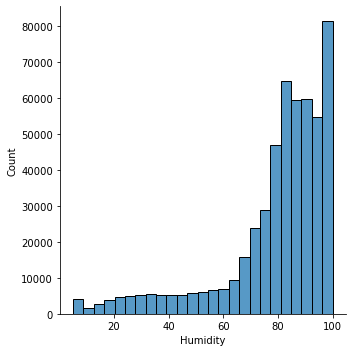

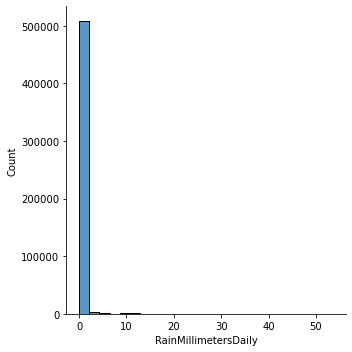

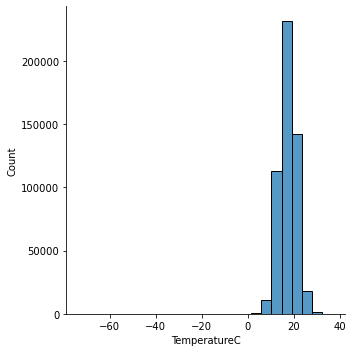

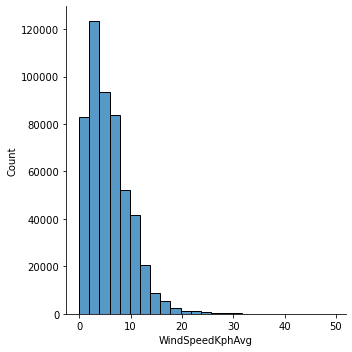

In [10]:
#Helper function for plotting frequencies
def create_box_and_dist_plots(df,column,bins):
    sns.displot(df,x = column, bins = bins)

#Plot all of the columns in weather data
for col in weather.columns:
    create_box_and_dist_plots(weather,col,25)

#Sort the values by TemperatureC
weather.TemperatureC.sort_values().head(40)

#Filter out rows where the Temperature was less than 0 degrees celcius (Very unlikely in San Diego)
weather.TemperatureC = np.where(weather.TemperatureC <= 0, np.nan, weather.TemperatureC)

#Sort values by Temperature C (To check whether the extreme/incorrect values are gone)
weather.TemperatureC.sort_values().head(40)

In [11]:
#What we need: Is to check for missing days in the data

#Why do we need this? So we can fill in the missing days with previous days data. EX. from the previous day get the temperatureC

#How are we gonna do this? By having of range of days that covers all of our attendance data. In this instance it's

#01-07-2014 : 24-04-2019 <-- X, and essentially what's gnona end up happening is I'm gonna check whether the index of our DATAFRAMES
# is IN the range of dates X

#The first thing that I need to do, is aggregate it

#UPDATE:
#Tried to find missing dates by shape but turns out the resampling includes dates aggregated by 0 rows. This was very misleading
#As we thought there were no missing dates. This block of code is for educational purposes only and will not be compiled
#-------------------------------------------------------------------------------------------------------------------------
# print(weather_data.iloc[0].name) #references the name of the first row
# print(weather_data.iloc[len(weather_data)-1].name)#references the name of the last row

# weather_data.index.difference(pd.date_range(start = weather_data.iloc[0].name, end = weather_data.iloc[len(weather_data)-1].name))

# #Theoretically if we have no missing days, than rows should be equal to each other
# print(weather_data.shape)
# print(pd.date_range(start = weather_data.iloc[0].name, end = weather_data.iloc[len(weather_data)-1].name).shape)

# #this is backwards
# pd.date_range(start = weather_data.iloc[0].name, end = weather_data.iloc[len(weather_data)-1].name).difference(weather_data.index)
# #-----------------------------------------------------------------------------------------------------

In [12]:
#Aggregating rows by days and counting
weather_temp = weather.resample('D').count()

#Theoretically, the rows which have count of 0 are being aggregated by 0 rows
print(weather_temp[weather_temp.TemperatureC == 0])

                           Humidity  RainMillimetersDaily  TemperatureC  \
ObservationTimeUtc                                                        
2015-10-21 00:00:00-07:00         0                     0             0   
2015-10-22 00:00:00-07:00         0                     0             0   
2015-10-23 00:00:00-07:00         0                     0             0   
2015-10-24 00:00:00-07:00         0                     0             0   
2015-10-25 00:00:00-07:00         0                     0             0   
2015-10-26 00:00:00-07:00         0                     0             0   
2015-10-27 00:00:00-07:00         0                     0             0   

                           WindSpeedKphAvg  
ObservationTimeUtc                          
2015-10-21 00:00:00-07:00                0  
2015-10-22 00:00:00-07:00                0  
2015-10-23 00:00:00-07:00                0  
2015-10-24 00:00:00-07:00                0  
2015-10-25 00:00:00-07:00                0  
2015-10-2

In [13]:
#Dates 2015-10-21:27 are empty and return 0 rows in the weather data
print(weather['2015-10-26'].tail(50))

#Let's get the index of the dates being aggregated by 0 rows
print(weather_temp[weather_temp.TemperatureC == 0].index)

#The most recent day is 2015-10-20, therefore we will substitute the whole week with that
#Let's postpone this issue and aggregate by mean, median, max, and min. (NOTE: missing values will be np.nan but we can simply
#substitute 2015-10-20's data after it's aggregated by mean, median, max, min)
#After that, we will take care of the missing values


Empty DataFrame
Columns: [Humidity, RainMillimetersDaily, TemperatureC, WindSpeedKphAvg]
Index: []
DatetimeIndex(['2015-10-21 00:00:00-07:00', '2015-10-22 00:00:00-07:00',
               '2015-10-23 00:00:00-07:00', '2015-10-24 00:00:00-07:00',
               '2015-10-25 00:00:00-07:00', '2015-10-26 00:00:00-07:00',
               '2015-10-27 00:00:00-07:00'],
              dtype='datetime64[ns, US/Pacific]', name='ObservationTimeUtc', freq='D')


<ipython-input-13-3240fc9d9607>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  print(weather['2015-10-26'].tail(50))


In [14]:
#Mean, min, max, median of TemperatureC from 9am to 5pm aggregated by days
weather_9_5_mean = (weather.between_time('09:00:00','17:00:00').resample('D').mean())
weather_9_5_mean.columns = ['Humidity_9_5_mean','RainMillimetersDaily_9_5_mean','TemperatureC_9_5_mean','WindSpeedKphAvg_9_5_mean']

weather_9_5_min = (weather.between_time('09:00:00','17:00:00').resample('D').min())
weather_9_5_min.columns = ['Humidity_9_5_min','RainMillimetersDaily_9_5_min','TemperatureC_9_5_min','WindSpeedKphAvg_9_5_min']

weather_9_5_max = (weather.between_time('09:00:00','17:00:00').resample('D').max())
weather_9_5_max.columns = ['Humidity_9_5_max','RainMillimetersDaily_9_5_max','TemperatureC_9_5_max','WindSpeedKphAvg_9_5_max']

weather_9_5_median = (weather.between_time('09:00:00','17:00:00').resample('D').median())
weather_9_5_median.columns = ['Humidity_9_5_median','RainMillimetersDaily_9_5_median','TemperatureC_9_5_median','WindSpeedKphAvg_9_5_median']

In [15]:
#Mean, min, max, median of TemperatureC from 6am to 9am aggregated by days
weather_6_9_mean = (weather.between_time('06:00:00','09:00:00').resample('D').mean())
weather_6_9_mean.columns = ['Humidity_6_9_mean','RainMillimetersDaily_6_9_mean','TemperatureC_6_9_mean','WindSpeedKphAvg_6_9_mean']

weather_6_9_min = (weather.between_time('06:00:00','09:00:00').resample('D').min())
weather_6_9_min.columns = ['Humidity_6_9_min','RainMillimetersDaily_6_9_min','TemperatureC_6_9_min','WindSpeedKphAvg_6_9_min']

weather_6_9_max = (weather.between_time('06:00:00','09:00:00').resample('D').max())
weather_6_9_max.columns = ['Humidity_6_9_max','RainMillimetersDaily_6_9_max','TemperatureC_6_9_max','WindSpeedKphAvg_6_9_max']

weather_6_9_median = (weather.between_time('06:00:00','09:00:00').resample('D').median())
weather_6_9_median.columns = ['Humidity_6_9_median','RainMillimetersDaily_6_9_median','TemperatureC_6_9_median','WindSpeedKphAvg_6_9_median']


In [16]:
#Merge the columns above
weather_data = pd.concat([weather_6_9_mean, weather_9_5_mean, weather_6_9_min, weather_9_5_min, weather_6_9_max, weather_9_5_max, weather_6_9_median, weather_9_5_median], axis = 1)

In [17]:
#Let's deal with the missing dates by setting the week of 2015-10-21:27 to 2015-10-20
for i in range(1,8):
    weather_data.loc[str('2015-10-2'+str(i)),:] = weather_data.loc['2015-10-20'].values

In [18]:
print(weather_data[weather_data.Humidity_6_9_mean <= 20])


                           Humidity_6_9_mean  RainMillimetersDaily_6_9_mean  \
ObservationTimeUtc                                                            
2014-01-15 00:00:00-08:00          17.721100                          0.000   
2014-01-16 00:00:00-08:00          18.705552                          0.000   
2014-01-17 00:00:00-08:00          13.498652                          0.000   
2014-01-18 00:00:00-08:00          18.376021                          0.000   
2014-01-19 00:00:00-08:00          19.340430                          0.000   
2014-03-09 00:00:00-08:00          18.094441                          0.000   
2014-04-30 00:00:00-07:00          10.034036                          0.000   
2014-05-01 00:00:00-07:00          10.346924                          0.000   
2014-05-13 00:00:00-07:00          13.289709                          0.000   
2014-05-14 00:00:00-07:00          10.446885                          0.000   
2014-05-15 00:00:00-07:00          14.323704        

In [19]:
#Merge the weather_data with the attendance data on days
full_data = attendance.join(weather_data,how = 'left')

In [20]:
print(full_data[full_data.Humidity_6_9_mean.isnull()].Humidity_6_9_mean)


Date
2015-02-14 00:00:00-08:00   NaN
2016-05-18 00:00:00-07:00   NaN
2019-01-01 00:00:00-08:00   NaN
2019-01-02 00:00:00-08:00   NaN
2019-01-03 00:00:00-08:00   NaN
                             ..
2019-06-26 00:00:00-07:00   NaN
2019-06-27 00:00:00-07:00   NaN
2019-06-28 00:00:00-07:00   NaN
2019-06-29 00:00:00-07:00   NaN
2019-06-30 00:00:00-07:00   NaN
Name: Humidity_6_9_mean, Length: 183, dtype: float64


In [21]:
# Checking for data in 'Full Paid' feature and dropping rows with nulls
full_data['Full Paid'] = full_data['Full Paid'].astype('float')
full_data = full_data[np.isnan(full_data['Full Paid'])== False]

#Checking why RainMillimeters is 0 or nan for most of the rows.
#It's because rain doesn't happen frequently in San Diego
print(full_data.RainMillimetersDaily_9_5_median[full_data.RainMillimetersDaily_9_5_median != 0].shape)

(289,)


In [22]:
#Filling in null values with zeros
# full_data = full_data.fillna(0)

In [23]:
#Check where Total On-Site Visitors is incorrect:
#will need columns 1 through 13 to sum up to column 14
x=(full_data.iloc[:,1:13].sum(axis = 1))
y=(full_data.iloc[:,13])

In [24]:
#Easy, fix, just set Total On-Site Visitors to the sum of all 13 columns
full_data['Total On-Site Visitors'] = full_data.iloc[:,1:13].sum(axis = 1)

In [25]:
#--------------------------------------FEATURE ENGINEERING-------------------------------------------------------------------#

In [26]:
#Create lagged variables: 1 day ago, 2 days ago, 3 days ago, 4 days ago, 7 days ago
full_data['Total On-Site Visitors_lag1'] = full_data['Total On-Site Visitors'].shift(freq='1D')
full_data['Total On-Site Visitors_lag2'] = full_data['Total On-Site Visitors'].shift(freq='2D')
full_data['Total On-Site Visitors_lag3'] = full_data['Total On-Site Visitors'].shift(freq='3D')
full_data['Total On-Site Visitors_lag4'] = full_data['Total On-Site Visitors'].shift(freq='4D')
full_data['Total On-Site Visitors_lag7'] = full_data['Total On-Site Visitors'].shift(freq='7D')
#------------------------------------------------------------------------------------------

#Same day of the week a year ago (Attempt) Fit one model with this variable and one without it
full_data['Total On-Site Visitors_lag_year'] = full_data['Total On-Site Visitors'].shift(freq='364D')
#------------------------------------------------------------------------------------------

#dummy variables for day of the week. Only need 6 dummies
full_data['Day'] = full_data.index.day_name()
#Now use pd.getdummies() on Day to get 6 dummy variables. OR state in R function when modeling
#------------------------------------------------------------------------------------------

#Dummy variable for weekend vs. business day
full_data['Weekday_att'] = np.where(full_data.index.day_name().isin(['Monday','Tuesday','Wednesday','Thursday','Friday']),1,0)
#------------------------------------------------------------------------------------------

#Dummy variable for months
full_data['Month'] = full_data.index.month_name()
#Now use pd.getdummies() on Month to get 11 dummy variables. OR state in R function when modeling
#------------------------------------------------------------------------------------------

#Dummy for Paid Sp Events
full_data['Paid Sp Events_dummy']=np.where(full_data['Paid Sp Events']!=0,1,0)
#------------------------------------------------------------------------------------------

#Dummy for holiday
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()
holidays = cal.holidays(full_data.index[0], full_data.index[len(full_data)-1]).tz_convert('US/Pacific')
#consider using index.min and index.max above
full_data['Holidays'] = np.where(full_data.index.isin(holidays),1,0)
#------------------------------------------------------------------------------------------

#winter, summer, spring, thanksgiving, christmas, etc. school breaks
#This could be cleaner
full_data['School_breaks'] = np.where(
    (full_data.index.month == 11)&(full_data.index.day.isin(range(23,28)))|    #Thanksgiving
    ((full_data.index.month == 12)&(full_data.index.day.isin(range(21,32))))|  #Christmas Break
    (((full_data.index.month == 1)&(full_data.index.day==1)))|                 #Christmas Break
    (full_data.index.month == 2)&(full_data.index.day.isin(range(12,15)))|     #Mid-Winter Break
    ((full_data.index.month == 3)&(full_data.index.day.isin(range(29,32))))|   #Spring Break
    (((full_data.index.month == 4)&(full_data.index.day.isin(range(1,3)))))|   #Spring Break
    ((full_data.index.month == 6)&(full_data.index.day.isin(range(1,17))))|    #Summer Break
    (((full_data.index.month == 8)&(full_data.index.day.isin(range(1,28)))))|  #Summer Break
    (((full_data.index.month == 7))),                                          #Summer Break
    1,
    0)
#----------------------------------------------------------------------------------

In [27]:
# average previous attendance for the last 7 days and the last 28 days (rolling 7-day and 28-day averages)
full_data['Avg_last7'] = full_data['Total On-Site Visitors'].rolling('7D',closed = 'left',min_periods = 7).mean()
full_data['Avg_last28'] = full_data['Total On-Site Visitors'].rolling('28D',closed = 'left',min_periods = 28).mean()

# average of 2 most recent weekend days for weekends and average of 5 most recent business days for business days.
# Problem is that weekend is also a business day.
weekend = full_data[full_data.Weekday_att == 0].rolling(2,closed = 'left',min_periods = 2).mean()
weekday = full_data[full_data.Weekday_att == 1].rolling(5,closed = 'left',min_periods = 5).mean()
#weekend is also business day
#so why not include?
full_data['AVG_2Recent_WeekEnd_5Recent_WeekDay'] = pd.concat([weekend['Total On-Site Visitors'],weekday['Total On-Site Visitors']])

# average weekly (7 days) and monthly (28 days) attendance a year ago
full_data['Avg_last7_year_ago'] = full_data['Total On-Site Visitors'].shift(freq='364D').rolling('7D',closed = 'left',min_periods = 7).mean()
full_data['Avg_last28_year_ago'] = full_data['Total On-Site Visitors'].shift(freq='364D').rolling('28D',closed = 'left',min_periods = 28).mean()

#Making new binary variables and lagged variables
makeBinary(full_data,'RainMillimetersDaily_6_9_max')
makeBinary(full_data,'RainMillimetersDaily_9_5_mean')
makeBinary(full_data,'WindSpeedKphAvg_9_5_mean')
makeBinary(full_data,'WindSpeedKphAvg_6_9_max')
full_data['Has_RainMillimetersDaily_9_5_mean_lag1']= full_data['Has_RainMillimetersDaily_9_5_mean'].shift(1)
full_data['TemperatureC_9_5_max_lag1'] = full_data['TemperatureC_9_5_max'].shift(1)
full_data['Has_WindSpeedKphAvg_9_5_mean_lag1'] = full_data['Has_WindSpeedKphAvg_9_5_mean'].shift(1)

#replacing whitespace and dash with underscore
temp = [col.replace('-','_')for col in [col.replace(' ','_') for col in list(full_data.columns)]]
full_data.columns = temp

#Dropping variables that make up Total On-Site Visitors
full_data.drop(columns = ['Full_Paid', 'Discount_Paid', 'Comp._Visitors',
       'Member_Visitors', 'Member_Passes', 'Pre_Paid', 'Group_Sales',
       'College', 'Ed_Groups', 'Public_Act', 'Member_Events', 'Paid_Sp_Events'],inplace = True)

In [28]:
#---------------------------------------------Model Building------------------------------------------------------------------#

#Split the data into model building and hold_out
# model_building
model_building = full_data[full_data.index.year != 2018]
hold_out = full_data[full_data.index.year == 2018]

In [29]:
#Descriptive Statistics
model_building.describe()

,Total_On_Site_Visitors,Humidity_6_9_mean,RainMillimetersDaily_6_9_mean,TemperatureC_6_9_mean,WindSpeedKphAvg_6_9_mean,Humidity_9_5_mean,RainMillimetersDaily_9_5_mean,TemperatureC_9_5_mean,WindSpeedKphAvg_9_5_mean,Humidity_6_9_min,...,AVG_2Recent_WeekEnd_5Recent_WeekDay,Avg_last7_year_ago,Avg_last28_year_ago,Has_RainMillimetersDaily_6_9_max,Has_RainMillimetersDaily_9_5_mean,Has_WindSpeedKphAvg_9_5_mean,Has_WindSpeedKphAvg_6_9_max,Has_RainMillimetersDaily_9_5_mean_lag1,TemperatureC_9_5_max_lag1,Has_WindSpeedKphAvg_9_5_mean_lag1
count,1461.000000,1278.000000,1278.000000,1278.000000,1278.000000,1272.000000,1272.000000,1272.000000,1272.000000,1278.000000,...,1454.000000,1062.000000,978.000000,1461.000000,1461.000000,1461.0,1461.0,1460.000000,1272.000000,1460.0
mean,1209.971253,79.019124,0.146262,16.644779,4.712674,75.900341,0.268934,18.868209,7.665916,74.151366,...,1214.412036,1256.037665,1269.960086,0.179329,0.206023,1.0,1.0,0.205479,20.293368,1.0
std,638.749295,22.429717,1.124953,3.532765,3.059534,17.432148,1.664671,3.185467,3.117563,23.926719,...,555.604925,364.309222,293.163876,0.383759,0.404586,0.0,0.0,0.404190,3.373108,0.0
min,0.000000,5.000000,0.000000,4.623774,0.519376,5.000000,0.000000,8.007167,1.826392,5.000000,...,0.000000,525.142857,714.785714,0.000000,0.000000,1.0,1.0,0.000000,11.310131,1.0
25%,735.000000,73.640135,0.000000,14.213233,2.601135,71.599164,0.000000,16.453706,5.342158,68.164909,...,812.250000,960.071429,1041.705357,0.000000,0.000000,1.0,1.0,0.000000,17.773012,1.0
50%,1151.000000,85.907672,0.000000,16.370917,3.842486,80.832331,0.000000,18.660642,7.327656,80.385693,...,1158.100000,1219.571429,1258.607143,0.000000,0.000000,1.0,1.0,0.000000,20.174782,1.0
75%,1650.000000,94.365549,0.000000,19.444580,5.900288,86.922795,0.000000,21.117482,9.335680,91.323332,...,1604.050000,1505.928571,1429.741071,0.000000,0.000000,1.0,1.0,0.000000,22.469989,1.0
max,3650.000000,100.000000,18.309167,27.983821,27.218645,100.000000,25.297374,34.533687,28.708701,100.000000,...,3134.000000,2240.142857,2021.464286,1.000000,1.000000,1.0,1.0,1.000000,36.721351,1.0


C:\Users\antho\anaconda3\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


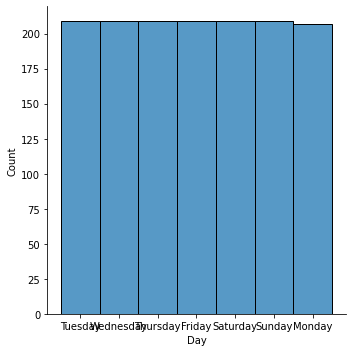

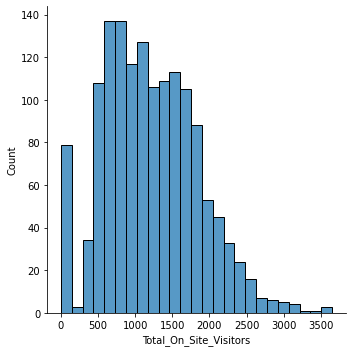

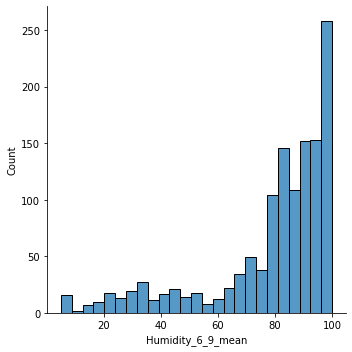

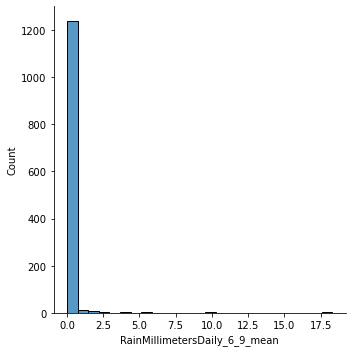

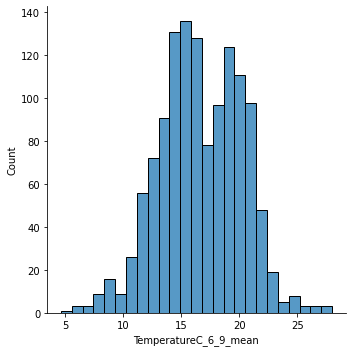

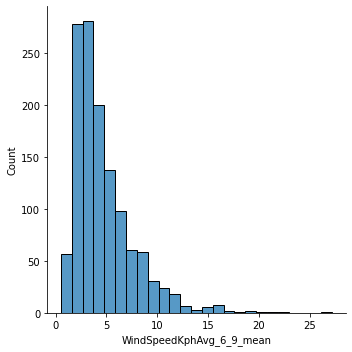

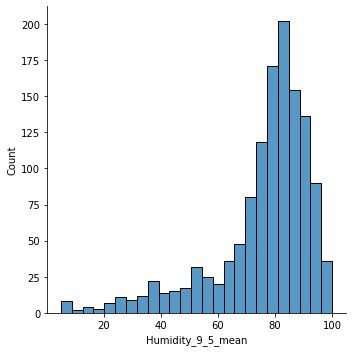

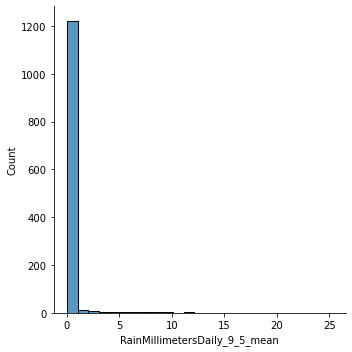

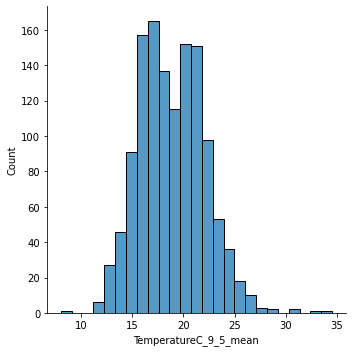

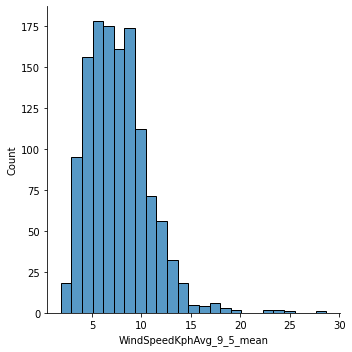

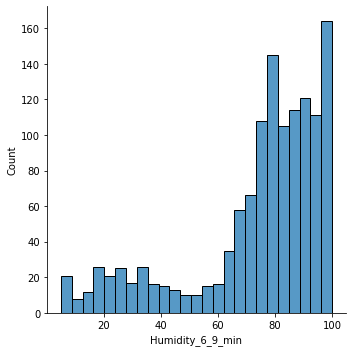

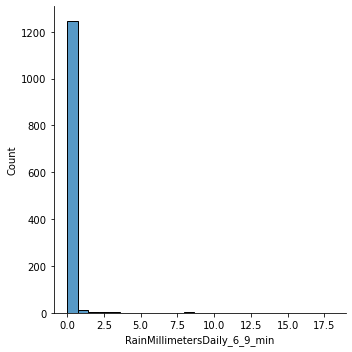

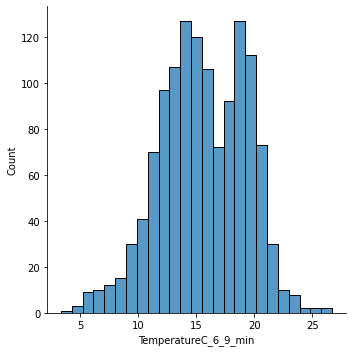

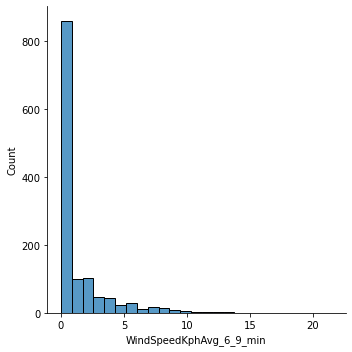

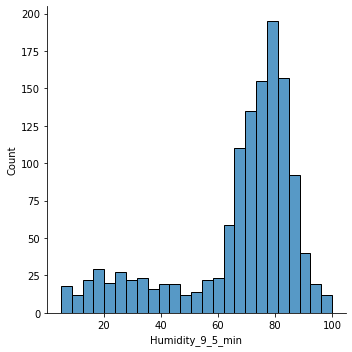

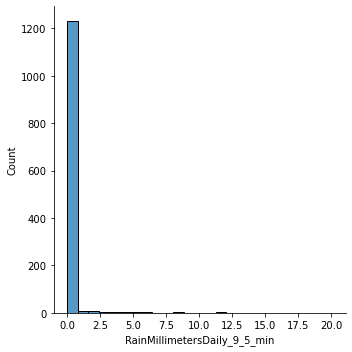

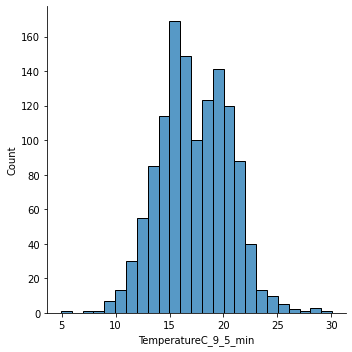

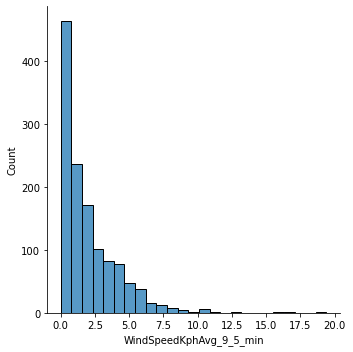

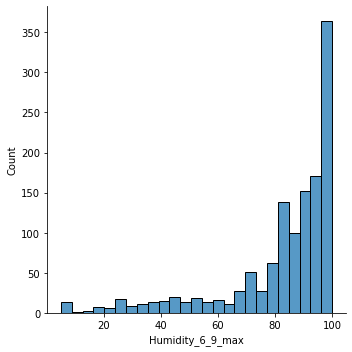

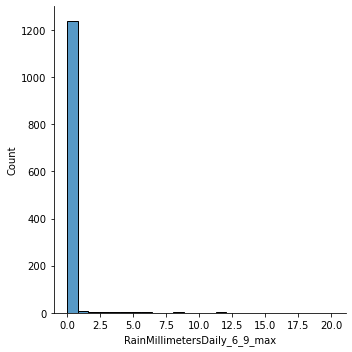

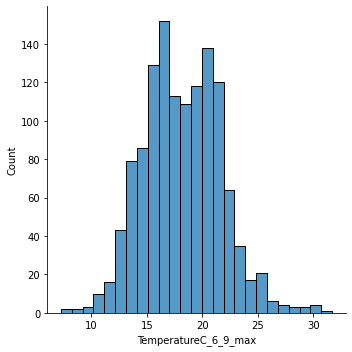

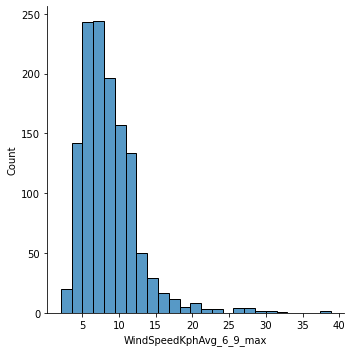

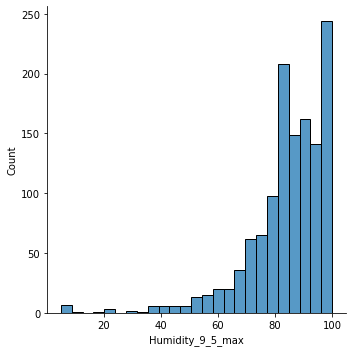

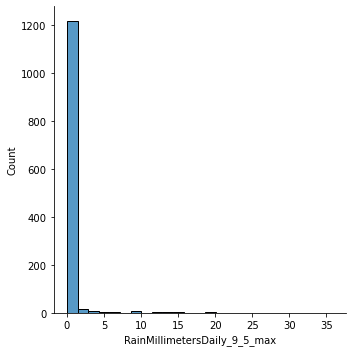

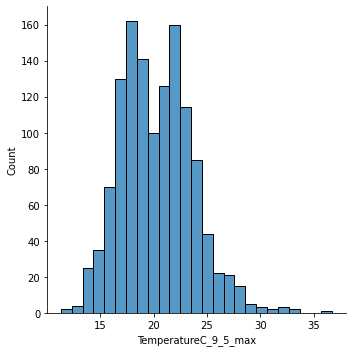

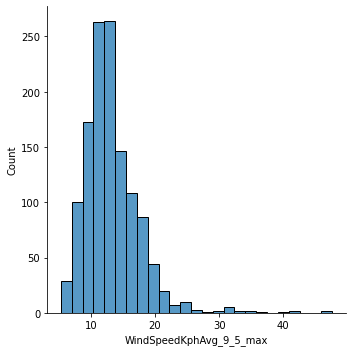

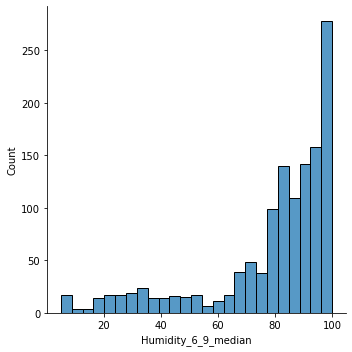

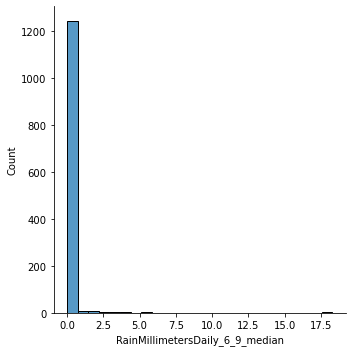

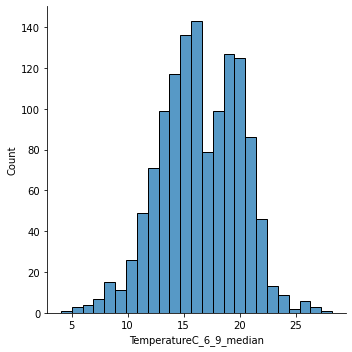

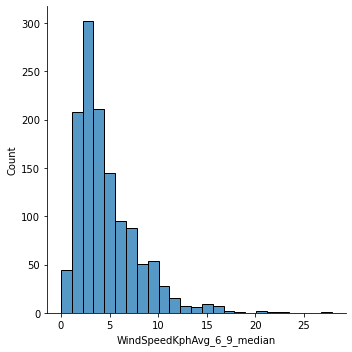

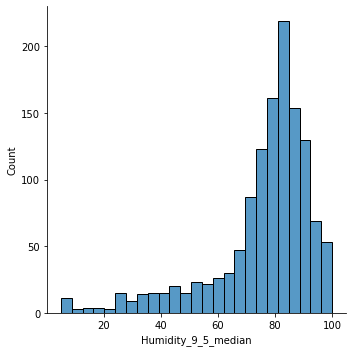

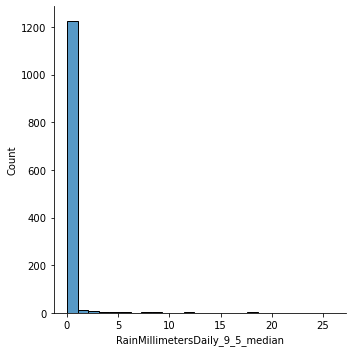

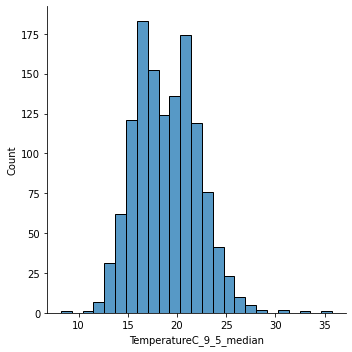

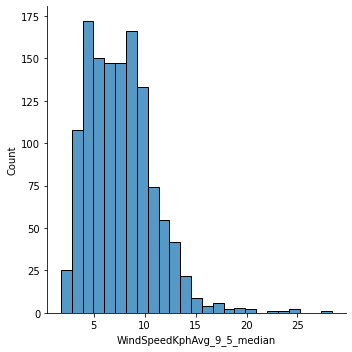

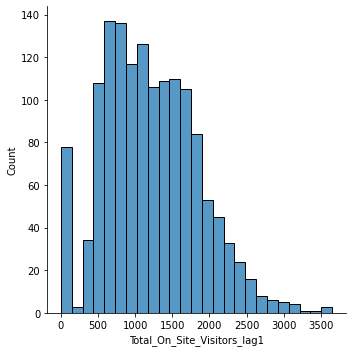

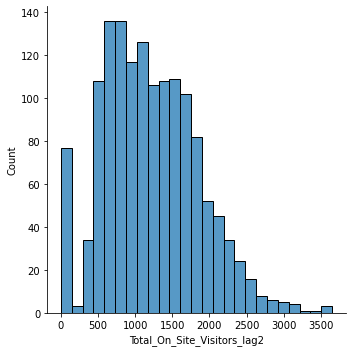

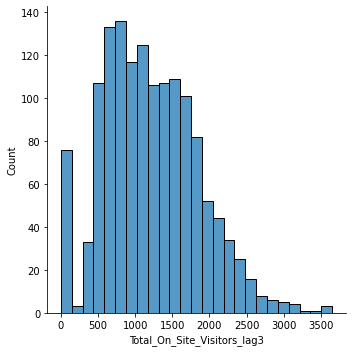

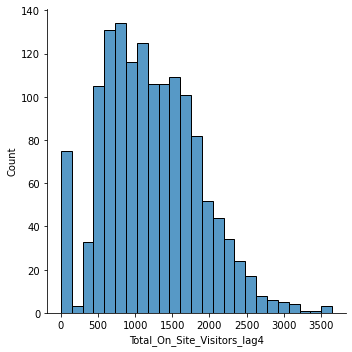

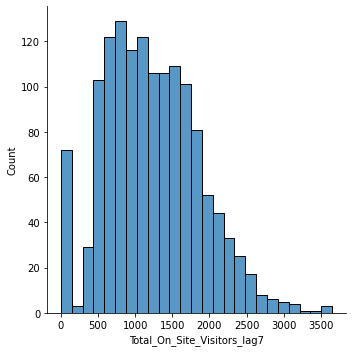

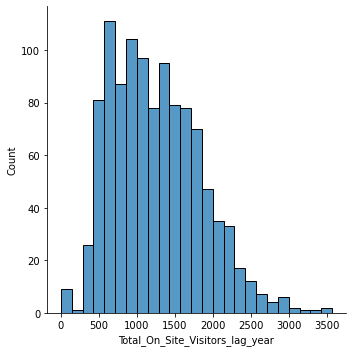

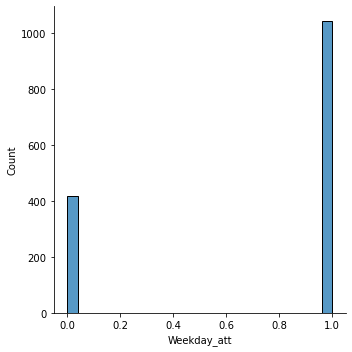

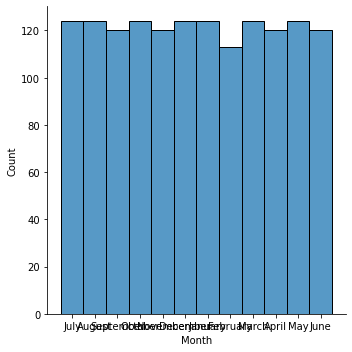

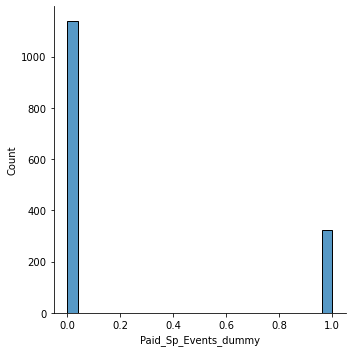

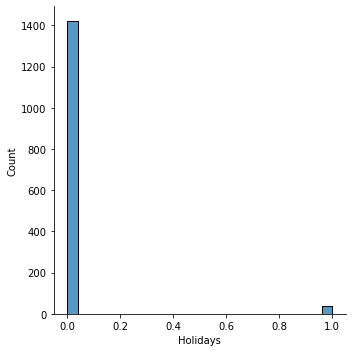

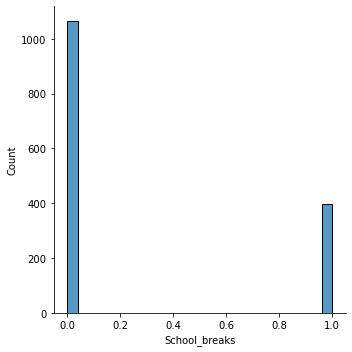

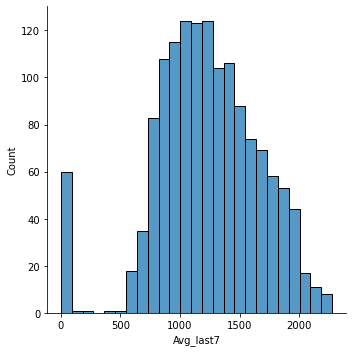

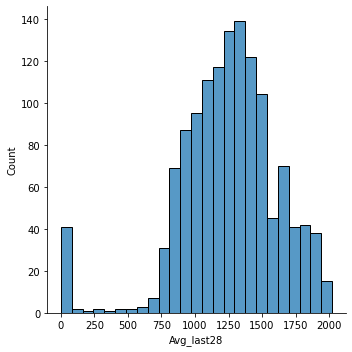

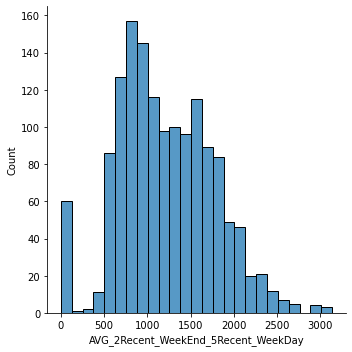

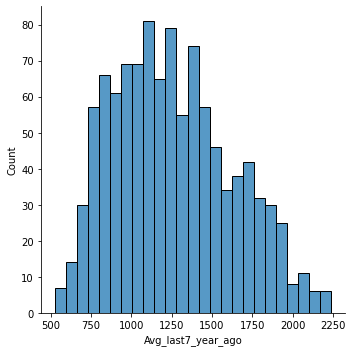

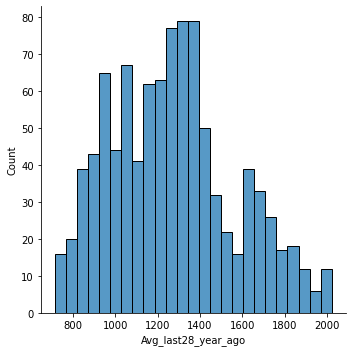

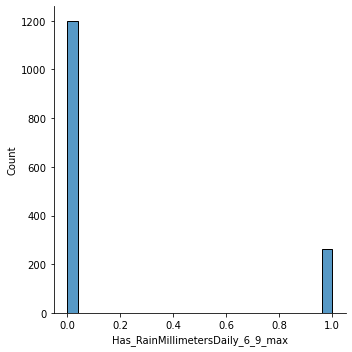

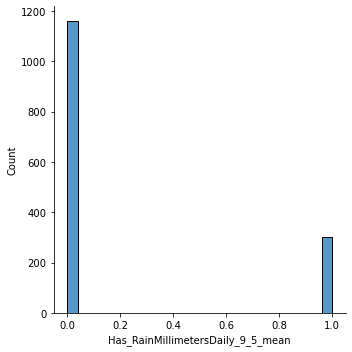

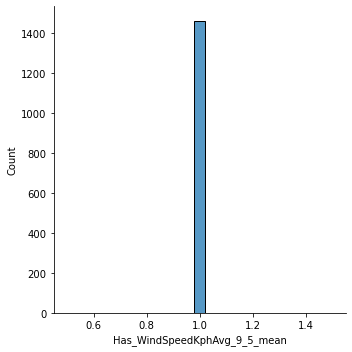

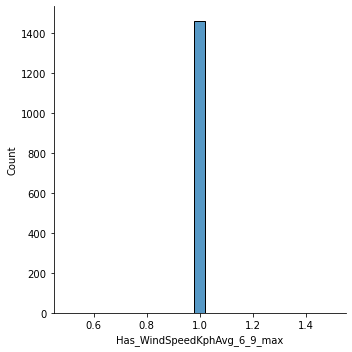

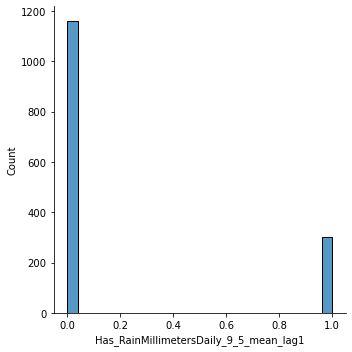

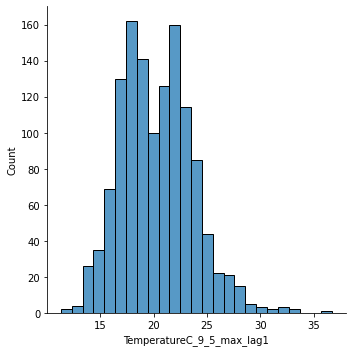

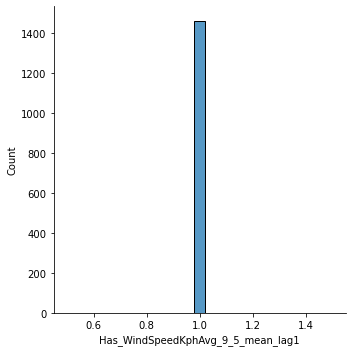

In [30]:
for col in model_building.columns:
    custom_plot(model_building,x= str(col),plot = 'histogram')

C:\Users\antho\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\antho\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\antho\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\antho\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\antho\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
<ipython-input-31-3f

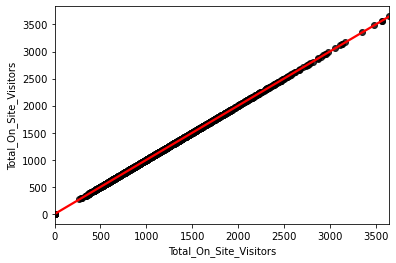

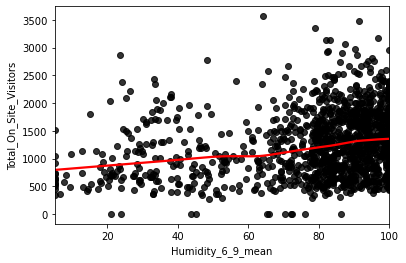

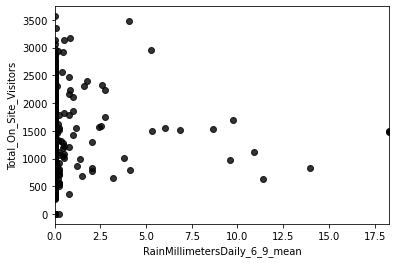

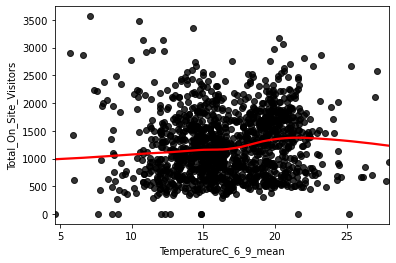

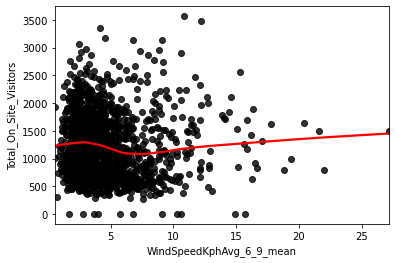

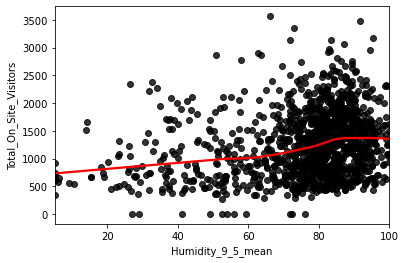

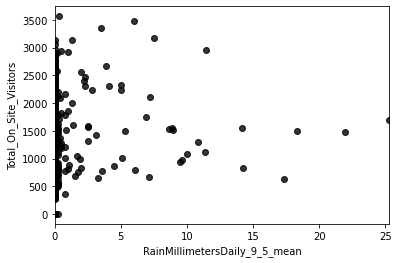

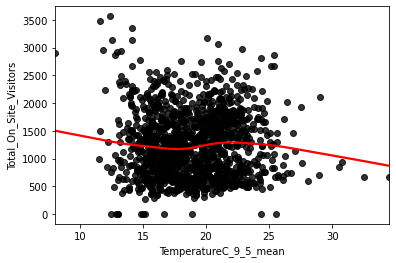

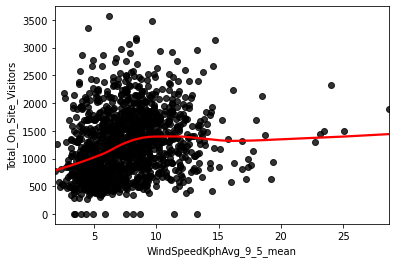

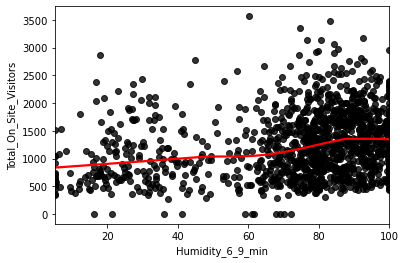

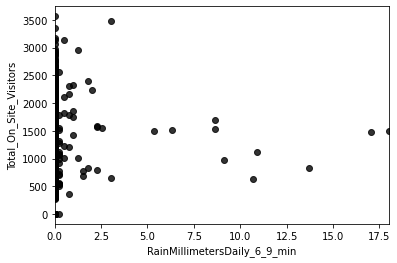

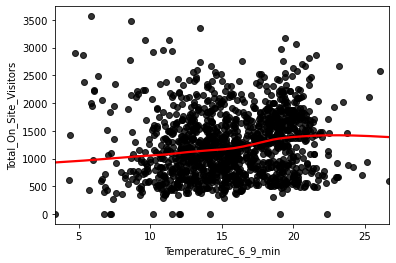

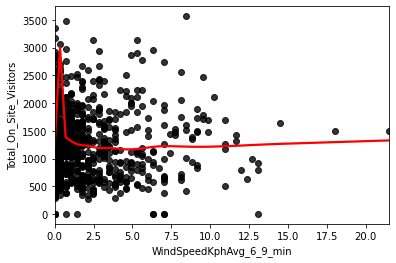

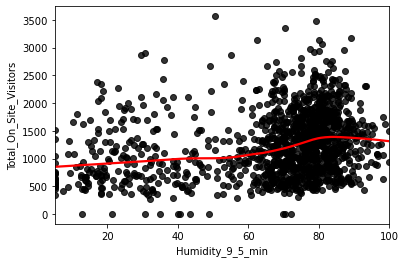

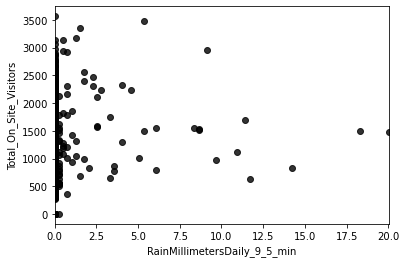

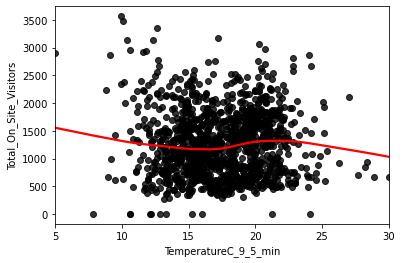

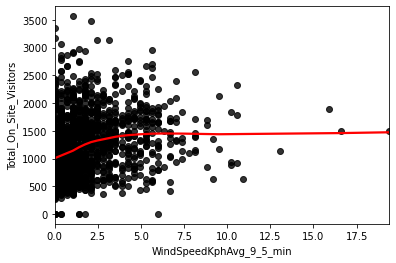

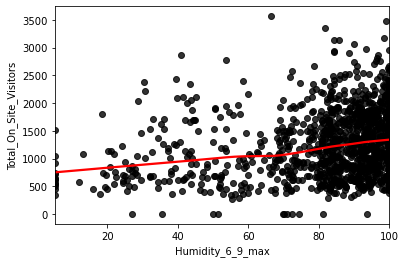

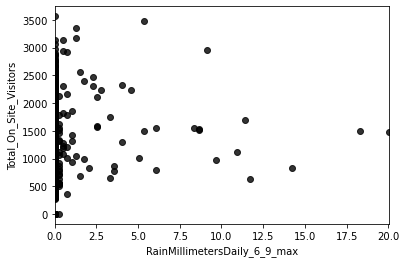

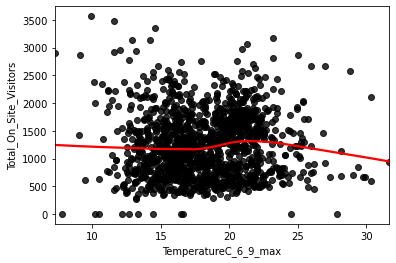

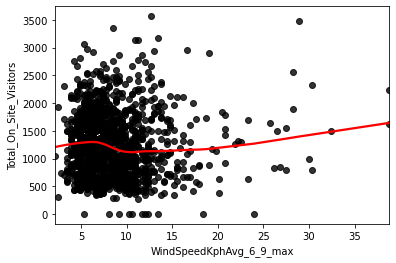

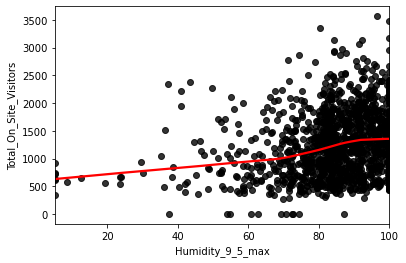

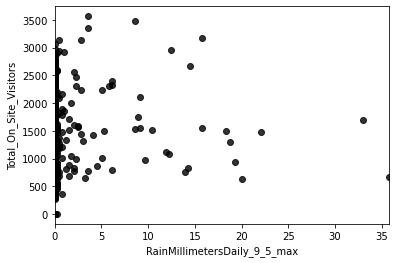

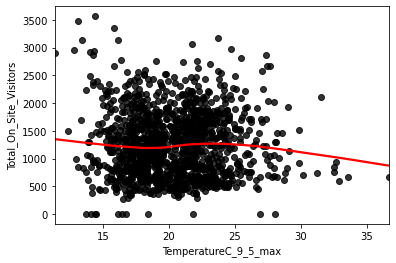

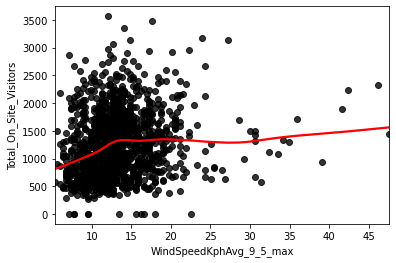

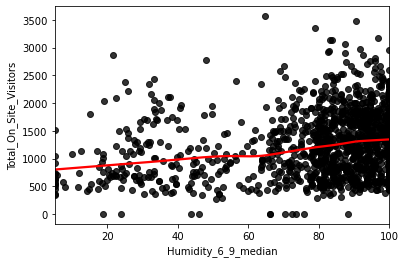

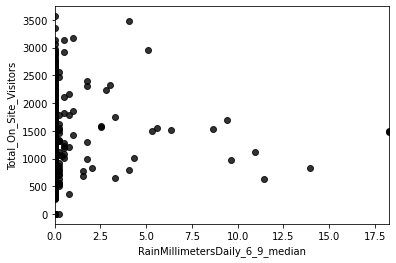

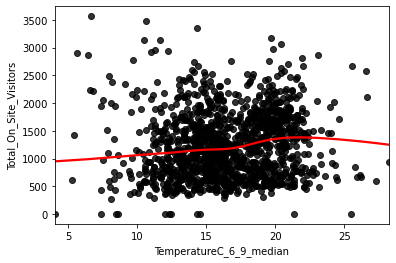

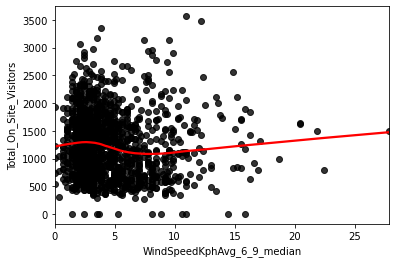

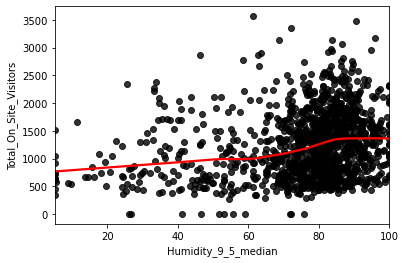

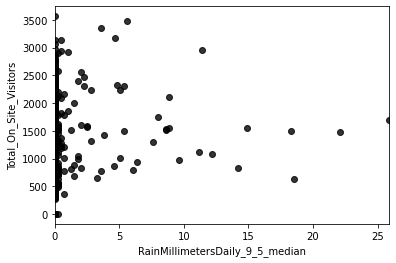

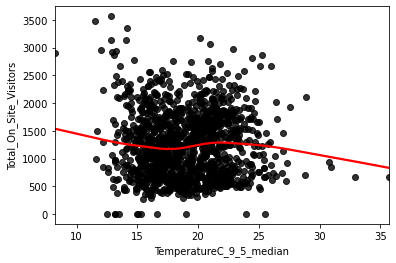

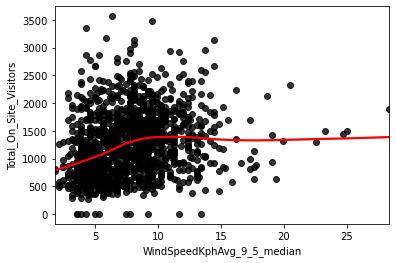

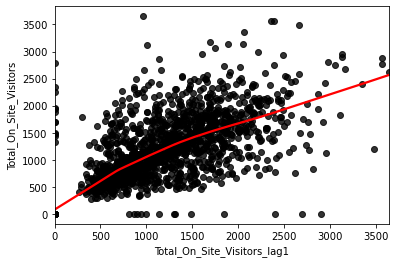

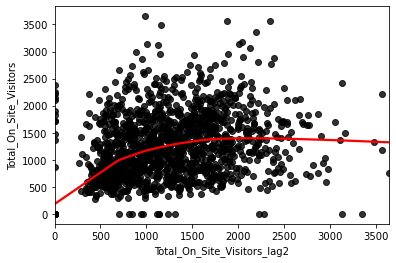

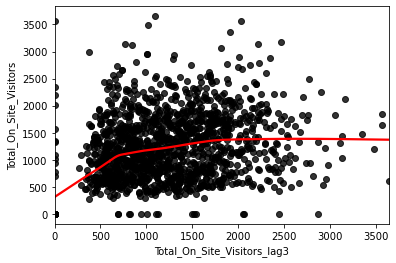

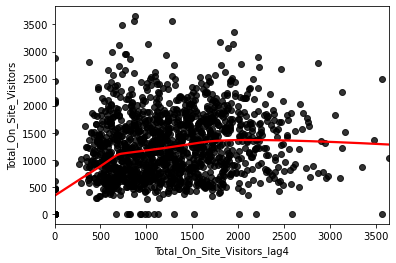

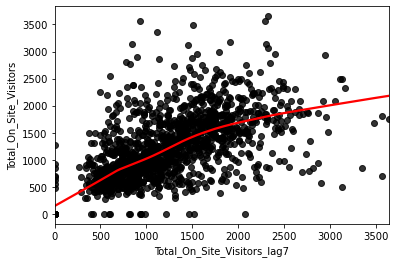

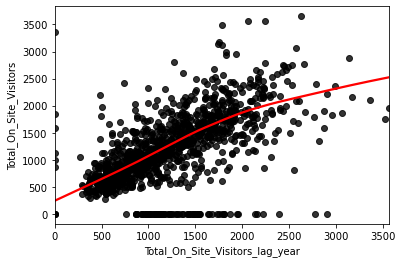

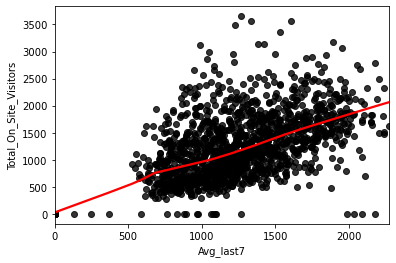

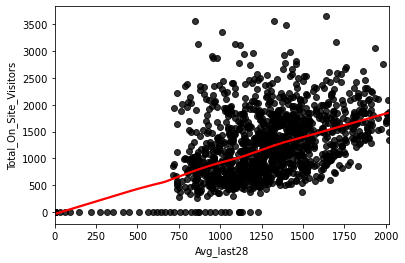

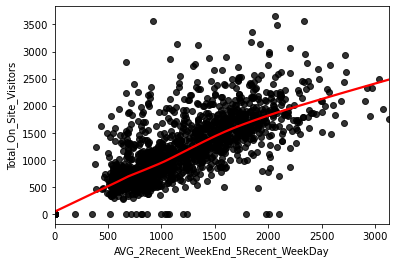

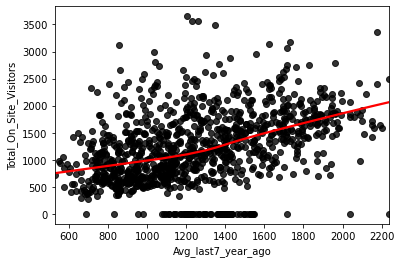

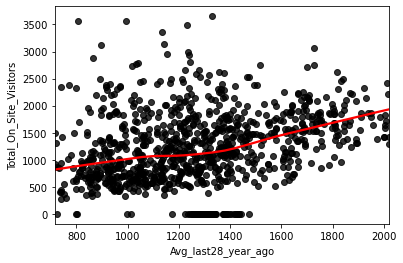

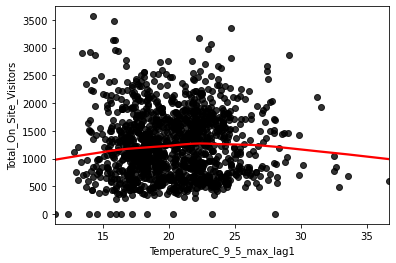

<Figure size 432x288 with 0 Axes>

In [31]:
#regplots against DV
for i in model_building.columns:
    if(len(model_building[i].unique()) > 13):
        custom_plot(model_building, x=i, y='Total_On_Site_Visitors',plot = 'regplot')
        plt.figure()


In [32]:
#first model
model = smf.ols(formula='Total_On_Site_Visitors ~Total_On_Site_Visitors_lag1 + AVG_2Recent_WeekEnd_5Recent_WeekDay ', data=model_building)
regression = model.fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Total_On_Site_Visitors   R-squared:                       0.564
Model:                                OLS   Adj. R-squared:                  0.564
Method:                     Least Squares   F-statistic:                     934.3
Date:                    Tue, 26 Oct 2021   Prob (F-statistic):          5.14e-261
Time:                            21:46:37   Log-Likelihood:                -10791.
No. Observations:                    1446   AIC:                         2.159e+04
Df Residuals:                        1443   BIC:                         2.160e+04
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                             119.3476     27.550      4.332      0.000      65.306     173.389
Total_On_Site_Visitors_lag1             0.2464      0.023     10.768      0.000       0.202       0.291
AVG_2Recent_WeekEnd_5Recent_WeekDay     0.6510      0.026     24.724      0.000       0.599       0.703
==============================================================================
Omnibus:                      217.234   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              851.898
Skew:                           0.680   Prob(JB):                    1.03e-185
Kurtosis:                       6.505   Cond. No.                     4.67e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
regression.predict(hold_out)


Date
2018-01-01 00:00:00-08:00    1612.688339
2018-01-02 00:00:00-08:00    1223.359824
2018-01-03 00:00:00-08:00    1537.313359
2018-01-04 00:00:00-08:00    1373.274039
2018-01-05 00:00:00-08:00    1186.398364
                                ...     
2018-12-27 00:00:00-08:00    1268.619707
2018-12-28 00:00:00-08:00    1567.956529
2018-12-29 00:00:00-08:00    1621.956813
2018-12-30 00:00:00-08:00    1967.571145
2018-12-31 00:00:00-08:00    1763.189131
Length: 365, dtype: float64

In [34]:
#Second model
#ADDED: Holidays, Total_On_Site_Visitors_lag1, Total_On_Site_Visitors_lag2, Total_On_Site_Visitors_lag3
# Total_On_Site_Visitors_lag4, Total_On_Site_Visitors_lag7, Total_On_Site_Visitors_lag_year 
# AVG_2Recent_WeekEnd_5Recent_WeekDay, C(Holidays), C(Month), C(School_breaks), C(Paid_Sp_Events_dummy)

model = smf.ols(formula=
                'Total_On_Site_Visitors~Total_On_Site_Visitors_lag1 + Total_On_Site_Visitors_lag2 + Total_On_Site_Visitors_lag3 + Total_On_Site_Visitors_lag4 + Total_On_Site_Visitors_lag7+Total_On_Site_Visitors_lag_year + AVG_2Recent_WeekEnd_5Recent_WeekDay + Holidays + Month + School_breaks + Paid_Sp_Events_dummy', data=model_building)
regression = model.fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Total_On_Site_Visitors   R-squared:                       0.676
Model:                                OLS   Adj. R-squared:                  0.670
Method:                     Least Squares   F-statistic:                     101.3
Date:                    Tue, 26 Oct 2021   Prob (F-statistic):          3.86e-232
Time:                            21:46:37   Log-Likelihood:                -7666.0
No. Observations:                    1041   AIC:                         1.538e+04
Df Residuals:                        1019   BIC:                         1.548e+04
Df Model:                              21                                         
Covariance Type:                nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                            -239.6946     64.470     -3.718      0.000    -366.204    -113.185
Month[T.August]                       -14.8230     66.242     -0.224      0.823    -144.810     115.164
Month[T.December]                     186.6130     61.072      3.056      0.002      66.772     306.454
Month[T.February]                     142.0882     58.979      2.409      0.016      26.353     257.823
Month[T.January]                       55.2711     58.387      0.947      0.344     -59.301     169.843
Month[T.July]                          14.6897     69.499      0.211      0.833    -121.687     151.067
Month[T.June]                         -47.1877     62.179     -0.759      0.448    -169.202      74.826
Month[T.March]                         65.2129     63.233      1.031      0.303     -58.869     189.295
Month[T.May]                           -1.1522     59.341     -0.019      0.985    -117.598     115.293
Month[T.November]                     137.3939     66.314      2.072      0.039       7.265     267.522
Month[T.October]                       81.9840     58.419      1.403      0.161     -32.650     196.618
Month[T.September]                    128.1938     58.902      2.176      0.030      12.612     243.776
Total_On_Site_Visitors_lag1             0.2575      0.029      8.757      0.000       0.200       0.315
Total_On_Site_Visitors_lag2            -0.0153      0.029     -0.534      0.593      -0.071       0.041
Total_On_Site_Visitors_lag3             0.0288      0.029      1.011      0.312      -0.027       0.085
Total_On_Site_Visitors_lag4            -0.0046      0.025     -0.184      0.854      -0.054       0.045
Total_On_Site_Visitors_lag7             0.0403      0.039      1.036      0.301      -0.036       0.117
Total_On_Site_Visitors_lag_year         0.3336      0.028     11.987      0.000       0.279       0.388
AVG_2Recent_WeekEnd_5Recent_WeekDay     0.4447      0.055      8.045      0.000       0.336       0.553
Holidays                              -20.2836     77.778     -0.261      0.794    -172.907     132.340
School_breaks                          42.3737     42.854      0.989      0.323     -41.719     126.467
Paid_Sp_Events_dummy                  206.0669     29.966      6.877      0.000     147.264     264.869
==============================================================================
Omnibus:                      132.952   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              765.075
Skew:                           0.420   Prob(JB):                    7.35e-167
Kurtosis:                       7.115   Cond. No.                     4.51e+04
============================================

In [35]:
regression.predict(hold_out),hold_out.Total_On_Site_Visitors
model_building.columns

Index(['Day', 'Total_On_Site_Visitors', 'Humidity_6_9_mean',
       'RainMillimetersDaily_6_9_mean', 'TemperatureC_6_9_mean',
       'WindSpeedKphAvg_6_9_mean', 'Humidity_9_5_mean',
       'RainMillimetersDaily_9_5_mean', 'TemperatureC_9_5_mean',
       'WindSpeedKphAvg_9_5_mean', 'Humidity_6_9_min',
       'RainMillimetersDaily_6_9_min', 'TemperatureC_6_9_min',
       'WindSpeedKphAvg_6_9_min', 'Humidity_9_5_min',
       'RainMillimetersDaily_9_5_min', 'TemperatureC_9_5_min',
       'WindSpeedKphAvg_9_5_min', 'Humidity_6_9_max',
       'RainMillimetersDaily_6_9_max', 'TemperatureC_6_9_max',
       'WindSpeedKphAvg_6_9_max', 'Humidity_9_5_max',
       'RainMillimetersDaily_9_5_max', 'TemperatureC_9_5_max',
       'WindSpeedKphAvg_9_5_max', 'Humidity_6_9_median',
       'RainMillimetersDaily_6_9_median', 'TemperatureC_6_9_median',
       'WindSpeedKphAvg_6_9_median', 'Humidity_9_5_median',
       'RainMillimetersDaily_9_5_median', 'TemperatureC_9_5_median',
       'WindSpeedKphAvg_9_5_m

In [71]:
#Third model: Using step-wise elimination

#Start to implement interactions between dummy variables and lagged variables:
#---------------------------------Weather variables-------------------------
# Raining in the morning? RainMillimetersDaily_6_9_max * Has_RainMillimetersDaily_6_9_max
# Raining yesterday from 9 to 5? : Has_RainMillimetersDaily_9_5_mean_lag1
# Yesterday's 9 to 5 max temperature:  TemperatureC_9_5_max_lag1
# Yesterday Windspeed 9 to 5 max: WindSpeedKphAvg_9_5_max_lag1
# Min windspeed in the morning: WindSpeedKphAvg_6_9_min
# Max humidity in the morning: Humidity_6_9_max
# Min temperature in the morning: TemperatureC_6_9_max

#---------------------------------Rejected/Questions abt------------------------
# Last year's months: Total_On_Site_Visitors_lag_year * Month
# Last year's paid special events: Total_On_Site_Visitors_lag_year * Paid_Sp_Events_dummy
# Last year's holidays: Total_On_Site_Visitors_lag_year * Holidays
# Last year's School breaks: Total_On_Site_Visitors_lag_year * School_breaks

#----------------------------------lagged attendance variables------------------------------------
# attendance two days ago (Polynomial): Total_On_Site_Visitors_lag2 + (Total_On_Site_Visitors_lag2)**2
# Last year's attendance on that day: Total_On_Site_Visitors_lag_year
# last week's attendance on that day: Total_On_Site_Visitors_lag7
# Yesterday's attendance: Total_On_Site_Visitors_lag1

#------------------------------------Averages-------------------------------------------------
# Average 2 recent weekend and 5 recent weekday: AVG_2Recent_WeekEnd_5Recent_WeekDay
# Average attendance past 7 days: Avg_last7
# Average attendance past 28 days: Avg_last28
# Average attendance past 7 days, a year ago: Avg_last7_year_ago
# Average attendance past 28 days, a year ago: Avg_last28_year_ago

#-----------------------------------categorical variables----------------------------------------
# weekdays : Weekday_att
# Months: Month
# days with paid events: Paid_Sp_Events_dummy
# Holidays : Holidays
# Days where kids had breaks (highschool): School_breaks

model = smf.ols(formula='Total_On_Site_Visitors ~  Day+Total_On_Site_Visitors_lag_year+Avg_last28_year_ago + Avg_last28 + Has_RainMillimetersDaily_6_9_max+ + Has_RainMillimetersDaily_9_5_mean_lag1 + Total_On_Site_Visitors_lag_year + Total_On_Site_Visitors_lag1 + AVG_2Recent_WeekEnd_5Recent_WeekDay + Paid_Sp_Events_dummy'
                ,data = model_building)
regression = model.fit()
regression.summary()

#Removed:
# TemperatureC_6_9_max : 0.949 P-val
# Total_On_Site_Visitors_lag7: 0.782 P-val
# Total_On_Site_Visitors_lag2 + (Total_On_Site_Visitors_lag2)**2 : 0.490 P-val
# Avg_last28_year_ago: 0.428 P-val
# WindSpeedKphAvg_9_5_max_lag1 : 0.329 P-val
# TemperatureC_9_5_max_lag1: 0.229 P-val
# Humidity_6_9_max_log: 0.435 P-val
# WindSpeedKphAvg_6_9_min: 0.199 P-val
# Holidays: 0.212 P-val
# Avg_last7: 0.128 P-val
# Avg_last7_year_ago: 0.179 P-val
# Avg_last28: 0.143
# RainMillimetersDaily_6_9_max:C(Has_RainMillimetersDaily_6_9_max): .110 .283 for 0,1 respectively P-val
# School breaks: 0.276
# Weekday_att: 0.185

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Total_On_Site_Visitors   R-squared:                       0.707
Model:                                OLS   Adj. R-squared:                  0.703
Method:                     Least Squares   F-statistic:                     164.3
Date:                    Tue, 26 Oct 2021   Prob (F-statistic):          1.65e-242
Time:                            22:27:25   Log-Likelihood:                -7078.5
No. Observations:                     968   AIC:                         1.419e+04
Df Residuals:                         953   BIC:                         1.426e+04
Df Model:                              14                                         
Covariance Type:                nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 62.2509     62.891      0.990      0.323     -61.170     185.672
Day[T.Monday]                           -188.3242     47.160     -3.993      0.000    -280.874     -95.774
Day[T.Saturday]                          238.7396     52.833      4.519      0.000     135.058     342.422
Day[T.Sunday]                            -70.2942     50.533     -1.391      0.165    -169.462      28.874
Day[T.Thursday]                          -18.8008     44.008     -0.427      0.669    -105.164      67.563
Day[T.Tuesday]                           -79.8535     44.099     -1.811      0.070    -166.397       6.690
Day[T.Wednesday]                         -20.8445     43.927     -0.475      0.635    -107.050      65.361
Total_On_Site_Visitors_lag_year            0.2994      0.028     10.629      0.000       0.244       0.355
Avg_last28_year_ago                       -0.2970      0.055     -5.372      0.000      -0.406      -0.189
Avg_last28                                 0.2895      0.057      5.086      0.000       0.178       0.401
Has_RainMillimetersDaily_6_9_max         124.6193     43.354      2.874      0.004      39.540     209.699
Has_RainMillimetersDaily_9_5_mean_lag1  -158.6072     41.963     -3.780      0.000    -240.957     -76.257
Total_On_Site_Visitors_lag1                0.3545      0.030     11.961      0.000       0.296       0.413
AVG_2Recent_WeekEnd_5Recent_WeekDay        0.2866      0.041      6.907      0.000       0.205       0.368
Paid_Sp_Events_dummy                     159.7833     29.735      5.373      0.000     101.429     218.138
==============================================================================
Omnibus:                      136.908   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1083.359
Skew:                           0.366   Prob(JB):                    5.64e-236
Kurtosis:                       8.131   Cond. No.                     2.30e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

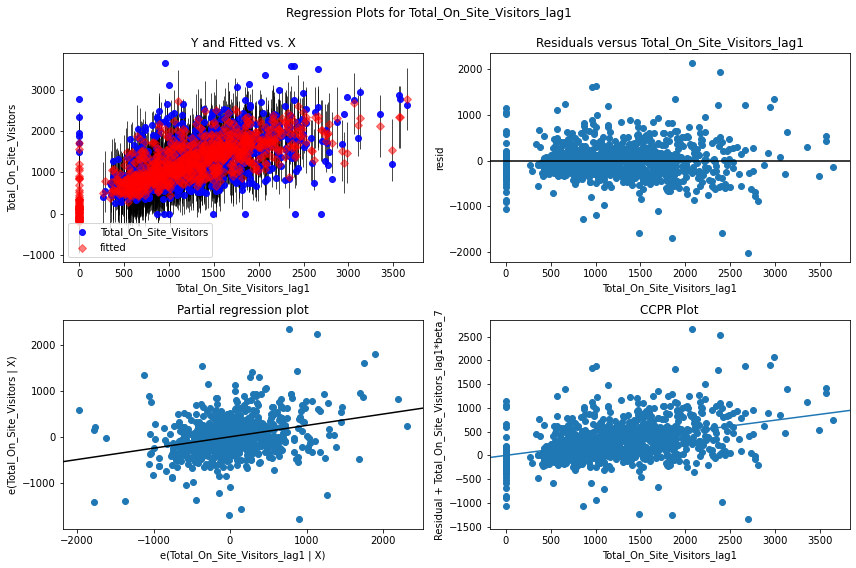

In [37]:
#Using residual analysis to examine serial correlation. There seems to be no autocorrelation over time for the lagged variables.
#We can see this by examining the residuals vs. independent lagged variable.

#Furthermore, Durbin Watson tests is 1.832, which is considered relatively normal. Autocorrelation is not an significant
#issue in this model.
import statsmodels.graphics.regressionplots as sm

#define figure size
fig = plt.figure(figsize=(12,8))
fig = sm.plot_regress_exog(regression, 'Total_On_Site_Visitors_lag1', fig=fig)


In [44]:
#Using vif values to examine multi-colinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = regression.model.exog
print(variables)
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
#Since all values (other than the intercept) are less than 5, multi-colinearity is not a significant issue.
vif

[[1.0000e+00 1.0000e+00 1.0000e+00 ... 1.6500e+03 1.8294e+03 0.0000e+00]
 [1.0000e+00 1.0000e+00 1.0000e+00 ... 1.8940e+03 1.7826e+03 1.0000e+00]
 [1.0000e+00 1.0000e+00 1.0000e+00 ... 1.8170e+03 1.8444e+03 0.0000e+00]
 ...
 [1.0000e+00 1.0000e+00 1.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.0000e+00 1.0000e+00 1.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.0000e+00 1.0000e+00 1.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]


C:\Users\antho\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


[0.0,
 0.0,
 0.0,
 1.8562239970106604,
 1.8790135391746416,
 3.7828436404279433,
 1.9723796997829661,
 2.4987067606163564,
 2.466278719220658,
 2.027059564487047,
 4.156957662769196,
 1.047357347902354]

In [72]:
print(regression.predict(hold_out),hold_out.Total_On_Site_Visitors)

Date
2018-01-01 00:00:00-08:00    1336.121147
2018-01-02 00:00:00-08:00     688.301392
2018-01-03 00:00:00-08:00    1227.987141
2018-01-04 00:00:00-08:00    1335.556894
2018-01-05 00:00:00-08:00    1036.168141
                                ...     
2018-12-27 00:00:00-08:00    1766.945576
2018-12-28 00:00:00-08:00    1910.101763
2018-12-29 00:00:00-08:00    2173.183034
2018-12-30 00:00:00-08:00    1872.929965
2018-12-31 00:00:00-08:00    1160.179657
Length: 365, dtype: float64 Date
2018-01-01 00:00:00-08:00       0.0
2018-01-02 00:00:00-08:00    1486.0
2018-01-03 00:00:00-08:00    1280.0
2018-01-04 00:00:00-08:00    1152.0
2018-01-05 00:00:00-08:00    1136.0
                              ...  
2018-12-27 00:00:00-08:00    2450.0
2018-12-28 00:00:00-08:00    2592.0
2018-12-29 00:00:00-08:00    2449.0
2018-12-30 00:00:00-08:00    2288.0
2018-12-31 00:00:00-08:00    2698.0
Name: Total_On_Site_Visitors, Length: 365, dtype: float64


In [85]:
#Using Robust Linear Model to deal with outliers in data
import statsmodels.api as sm


data.endog = model_building.Total_On_Site_Visitors

data.exog = model_building.loc[:,['Has_WindSpeedKphAvg_6_9_max','Has_WindSpeedKphAvg_9_5_mean_lag1','Total_On_Site_Visitors_lag_year','Avg_last28_year_ago' ,'Avg_last28','Weekday_att' , 'Has_RainMillimetersDaily_6_9_max', 'Has_RainMillimetersDaily_9_5_mean_lag1' ,'Total_On_Site_Visitors_lag_year' , 'Total_On_Site_Visitors_lag1' , 'AVG_2Recent_WeekEnd_5Recent_WeekDay' , 'Paid_Sp_Events_dummy']].fillna(0)

# Fit model and print summary
rlm_model = sm.RLM(data.endog, data.exog, M=sm.robust.norms.HuberT())

rlm_results = rlm_model.fit()

print(rlm_results.summary())
print(rlm_results.predict(hold_out.loc[:,['Has_WindSpeedKphAvg_6_9_max','Has_WindSpeedKphAvg_9_5_mean_lag1','Total_On_Site_Visitors_lag_year','Avg_last28_year_ago' ,'Avg_last28','Weekday_att' , 'Has_RainMillimetersDaily_6_9_max', 'Has_RainMillimetersDaily_9_5_mean_lag1' ,'Total_On_Site_Visitors_lag_year' , 'Total_On_Site_Visitors_lag1' , 'AVG_2Recent_WeekEnd_5Recent_WeekDay' , 'Paid_Sp_Events_dummy']]))


                      Robust linear Model Regression Results                      
Dep. Variable:     Total_On_Site_Visitors   No. Observations:                 1461
Model:                                RLM   Df Residuals:                     1450
Method:                              IRLS   Df Model:                           10
Norm:                              HuberT                                         
Scale Est.:                           mad                                         
Cov Type:                              H1                                         
Date:                    Tue, 26 Oct 2021                                         
Time:                            22:44:57                                         
No. Iterations:                        14                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------